In [14]:
import json
import pandas as pd
import numpy as np

#opens json file
with open('ultimate_data_challenge.json') as f:
    json_file = json.load(f)

#turns json file to DataFrame
df = pd.DataFrame(json_file)

In [15]:
#Creates Target Col for retension, as defined by the question
df['retained'] = df.trips_in_first_30_days.astype(bool).astype(np.float64)

#Convert Dtype of columns to be prep'd for machine learning
df['city'] = df.city.astype('category')
df['phone'] = df.phone.astype('category')
df['signup_date'] = pd.to_datetime(df.signup_date)
df['last_trip_date'] = pd.to_datetime(df.last_trip_date)
df['ultimate_black_user'] = df.ultimate_black_user.astype(np.float64)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
city                      50000 non-null category
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null datetime64[ns]
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null category
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null float64
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
retained                  50000 non-null float64
dtypes: category(2), datetime64[ns](2), float64(8), int64(1)
memory usage: 4.3 MB


Looking at the cell above, the dtype for many columns was transfromed to be prepared for machine learning.
There are three columns that have some missing values. Since 'phone' is a categorical with only 2 categoies, it seems reasonable to created a new 'Unknown' category. As for the numberic columns, a quick histogram will decide how to impute values.

In [16]:
df.phone.cat.add_categories(new_categories = 'Unknown', inplace=True)
df.phone.fillna('Unknown', inplace=True)
df.phone.value_counts()

iPhone     34582
Android    15022
Unknown      396
Name: phone, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


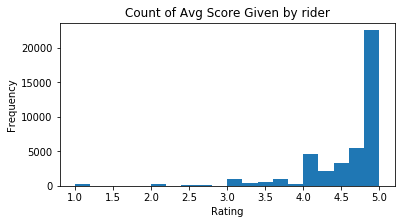

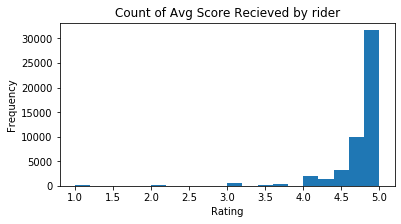

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
plt.hist(df.avg_rating_of_driver, 20)
plt.title('Count of Avg Score Given by rider')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6,3))
plt.hist(df.avg_rating_by_driver, 20)
plt.title('Count of Avg Score Recieved by rider')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

After plotting these historgram, it is clear that the distribution of ratings is strongly skewed left, and thus it would be better to impute the median value, rather than the mean value.

In [18]:
#Print Medians used for imputation
print('Imputed values: ')
print('avg_rating_of_driver: ', df.avg_rating_of_driver.median())
print('avg_rating_by_driver: ', df.avg_rating_by_driver.median())

#Impute values
df['avg_rating_of_driver'] = df.avg_rating_of_driver.fillna(df.avg_rating_of_driver.median())
df['avg_rating_by_driver'] = df.avg_rating_by_driver.fillna(df.avg_rating_by_driver.median())

Imputed values: 
avg_rating_of_driver:  4.9
avg_rating_by_driver:  5.0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
city                      50000 non-null category
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null datetime64[ns]
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null category
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null float64
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
retained                  50000 non-null float64
dtypes: category(2), datetime64[ns](2), float64(8), int64(1)
memory usage: 4.3 MB


Above, it is comfirmed that Null Values have been taken care of

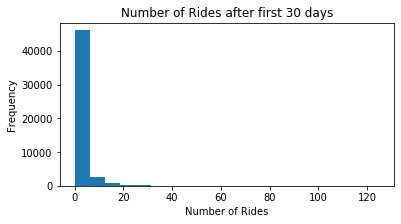

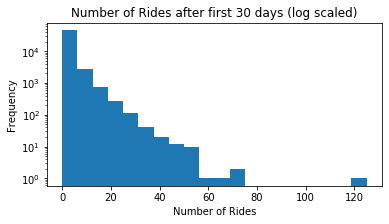

In [41]:
plt.figure(figsize=(6,3))
plt.hist(df.trips_in_first_30_days, 20)
plt.title('Number of Rides after first 30 days')
plt.xlabel('Number of Rides')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6,3))
plt.hist(df.trips_in_first_30_days, 20, log=True)
plt.title('Number of Rides after first 30 days (log scaled)')
plt.xlabel('Number of Rides')
plt.ylabel('Frequency')
plt.show()

Looking at the distribution of Number of Rides Taken During First 30 Days, it appears that most users use it less than 20, but a decent amount will still use it between the 20 to 50 times range. Then there are a few outliers of users using it more than 50 times, including someone who rode about 120 times in one month.

<BarContainer object of 7 artists>

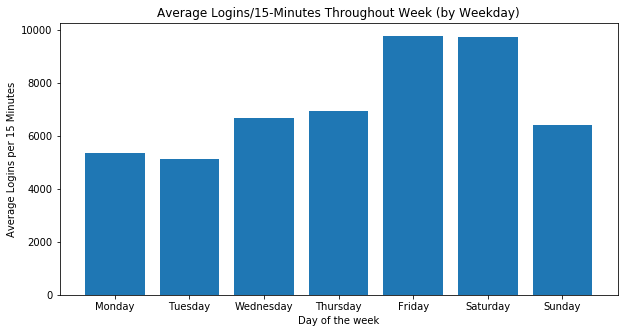

In [50]:
def TimeInvAnalysisAndPlot(df,col):

df_time_scale = pd.DataFrame({'signup_date':df.signup_date, 'counts': 1})
df_time_scale = df_time_scale.set_index(['signup_date'])

#creates counts of login withing 15 minutes interval
df_counts_15inv = df_time_scale.resample('15T').sum()

df_counts_15inv['year'] = df_counts_15inv.index.year
df_counts_15inv['month'] = df_counts_15inv.index.month
df_counts_15inv['day'] = df_counts_15inv.index.day
df_counts_15inv['hour'] = df_counts_15inv.index.hour
df_counts_15inv['minute'] = df_counts_15inv.index.minute
df_counts_15inv['weekday'] = df_counts_15inv.index.weekday
df_counts_15inv['time'] = df_counts_15inv.index.time

#Create Aggregate As Described by Graph Printed
x = df_counts_15inv.groupby('weekday').counts.sum().index
y = df_counts_15inv.groupby('weekday').counts.sum().values

#Choose Size
plt.figure(figsize=(10,5))
plt.title('Average Logins/15-Minutes Throughout Week (by Weekday)')
plt.ylabel('Average Logins per 15 Minutes')
plt.xlabel('Day of the week')
#add weekday labels to x axis
plt.xticks(x,labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.bar(x, y)

In [8]:
df.retained.value_counts()

1.0    34610
0.0    15390
Name: retained, dtype: int64